## Wiener process

$$
W_{t+1} = W_t +  \sigma \sqrt{\Delta t}\,\epsilon_t,
\quad \epsilon_t \sim \mathcal{N}(0, I)
$$

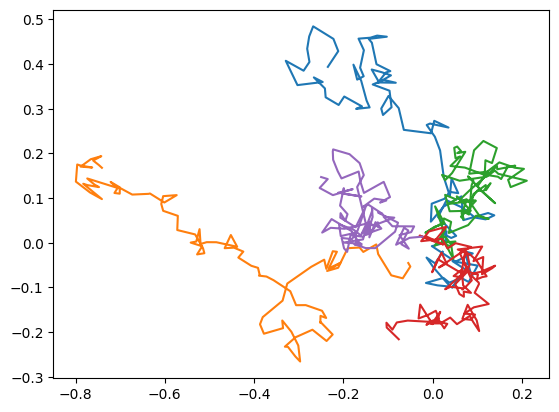

In [34]:
# brownian motion visualization

import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp, random

N = 100
N_TRAJ = 5
DT = 0.05; SIGMA = 0.1

def generate_traj(key, SIGMA=SIGMA):
    increments = random.normal(key, (N, 2))*SIGMA*jnp.sqrt(DT)

    traj = jnp.cumulative_sum(increments, axis=0)
    X, Y = jnp.split(traj, 2, axis=1)
    return X, Y

key = random.key(0)
keys = random.split(key, N_TRAJ)
Xs, Ys = jax.vmap(generate_traj)(keys)

fig, ax = plt.subplots()
for i in range(N_TRAJ):
    ax.plot(Xs[i], Ys[i])
ax.set_aspect(aspect='equal', adjustable="box")

## OU Process
The OU process generates temporally correlated noise, which can be useful for smooth control in continuous action spaces. In continuous time:

**OU is a mean‑reverting Wiener process**. 
1. First, it supply noise accumulaiton like Wiener process.
2. Second it pull back the accumulated drift so that "bound" the process somehow. 

The second point make it suitable for RL exploration. Furthermore, OU noise is more moother than random walk.

$$
dX_t = \theta(\mu - X_t)\,dt + \sigma\,dW_t
$$

- $\theta$ controls the mean-reversion speed.
- $\mu$ is the long-term mean (often 0 for exploration noise).
- $\sigma$ controls the noise scale.
- $W_t$ is standard Brownian motion.

Discrete-time Update
With time step $\Delta t$:

$$
X_{t+1} = X_t + \theta(\mu - X_t)\Delta t + \sigma \sqrt{\Delta t}\,\epsilon_t,
\quad \epsilon_t \sim \mathcal{N}(0, I)
$$


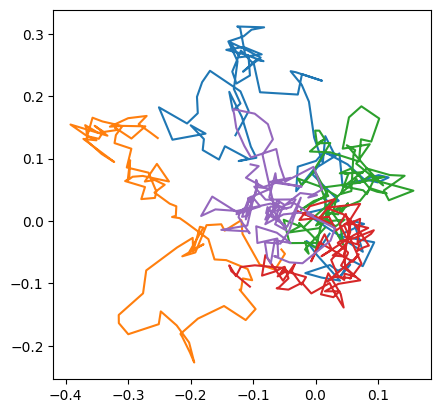

In [30]:
# OU process

import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp, random

# N = 100
# N_TRAJ = 10
# SIGMA = 0.1
THETA = 0.4; MU = jnp.array([0., 0.]); DT = 0.05
key = random.key(0)

def generate_traj(key, THETA=THETA, MU=MU, SIGMA=SIGMA, DT=DT):
    normal_noise = random.normal(key, (N, 2))
    def fn(x, noise):
        dx = THETA*(MU - x)*DT + SIGMA*noise*jnp.sqrt(DT)
        x = x + dx
        return x, x

    x, xs = jax.lax.scan(fn, jnp.array([0., 0.]), normal_noise)
    Xs, Ys = jnp.split(xs, 2, axis=1)
    return Xs, Ys

key = random.key(0)
keys = random.split(key, N_TRAJ)
Xs, Ys = jax.vmap(generate_traj)(keys)

fig, ax = plt.subplots()
for i in range(N_TRAJ):
    ax.plot(Xs[i], Ys[i])
ax.set_aspect(aspect='equal', adjustable="box")

### from wiener process to OU process

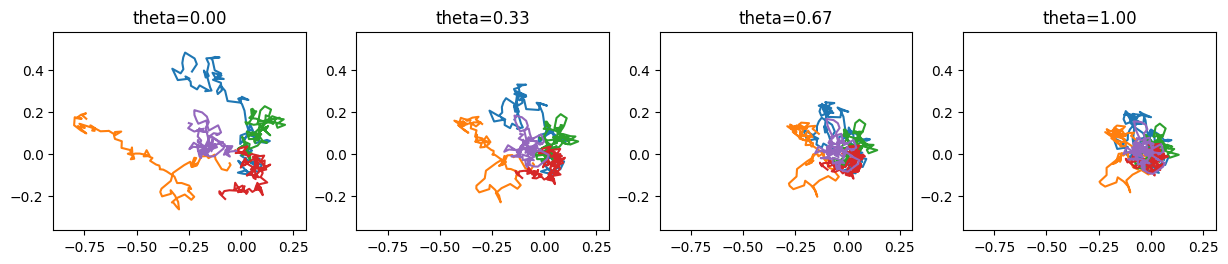

In [33]:
N = 100
N_TRAJ = 5
SIGMA = 0.1; THETA = 0.4; MU = jnp.array([0., 0.]); DT = 0.05
NUM_THETA = 4

def generate_trajs(theta):
    key = random.key(0)
    keys = random.split(key, N_TRAJ)
    gen_traj_ = lambda key: generate_traj(key, THETA=theta)
    return jax.vmap(gen_traj_)(keys)
 
thetas = jnp.linspace(0., 1.0, NUM_THETA)
Xs, Ys = jax.vmap(generate_trajs)(thetas)

fig, axes = plt.subplots(1, NUM_THETA, figsize=(15, 4))
for j in range(NUM_THETA):
    for i in range(N_TRAJ):
        axes[j].plot(Xs[j][i], Ys[j][i])
    axes[j].set_aspect(aspect='equal', adjustable="box")
    axes[j].set_xlim(jnp.min(Xs[0])-0.1, jnp.max(Xs[0])+0.1)
    axes[j].set_ylim(jnp.min(Ys[0])-0.1, jnp.max(Ys[0])+0.1)
    axes[j].set_title(f"theta={thetas[j]:.2f}")

## Apply OU noise to RL exploration

For example, DDPG applies OU noise to the deterministic actor output:

$$
a_t = \pi_\phi(s_t) + X_t
$$

Then actions are clipped to the environment action bounds. The OU state $X_t$ is carried across steps during rollout, so the noise is temporally correlated.